In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

**- 데이터 불러오기 및 확인**

In [237]:
from google.colab import drive
drive.mount('/content/drive')

#파일 경로는 필자 드라이브와 연결되어 있음. -> 타 계정 로그인 시 해당 파일 위치에 맞게 경로 변경 필요
file_path_train = '/content/drive/My Drive/BDA_contest/train.csv'
file_path_test = '/content/drive/My Drive/BDA_contest/test.csv'
file_path_sample_submission = '/content/drive/My Drive/BDA_contest/sample_submission.csv'

train = pd.read_csv(file_path_train)
test = pd.read_csv(file_path_test)
sample_submission = pd.read_csv(file_path_sample_submission)

train.head()
test.head()
sample_submission.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,completed
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [238]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               748 non-null    object 
 1   generation                       748 non-null    int64  
 2   school1                          748 non-null    int64  
 3   major type                       726 non-null    object 
 4   major1_1                         728 non-null    object 
 5   major1_2                         309 non-null    object 
 6   major_data                       748 non-null    bool   
 7   job                              748 non-null    object 
 8   class1                           748 non-null    int64  
 9   class2                           169 non-null    float64
 10  class3                           14 non-null     float64
 11  class4                           1 non-null      float64
 12  re_registration       

In [239]:
train.isna().sum()

,0
ID,0
generation,0
school1,0
major type,22
major1_1,20
major1_2,439
major_data,0
job,0
class1,0
class2,579


**- 데이터 전처리**
#의미있다고 판단한 열 목록
* major type : 복수전공 여부 ->복수전공자는 개인시간이 단일전공자보단 부족해 수료율이 낮을거라 예상.
* major_data : 제1전공 전공자 여부 ->전공자가 더 학습에 열의를 띄어 수료율이 높을거라 예상.
* job : 현재 직무 ->의미 있는 지표라 생각.
* class1~4 : 수강 분반 ->여러개를 수강하면 학습 집중 시간 부족으로 수료율이 낮을거라 예상.
* re_registration : 학기당 새로운 학회원을 모집할 때 재등록 여부 ->재등록한 학회원은 수료율도 높을거라 예상.
* inflow_route : 유입 경로 ->의미 있는 지표라 생각.
* hope_for_group : 조별활동 희망 여부 ->조별활동 희망자가 학습에 더 열의를 띄어 수료율이 높을거라 예상.
* major_field : 전공 분야 ->IT전공자 특성상 수료율이 높을거라 예상.
* desired_career_path : 희망 진로 ->의미있는 지표라 생각.
* completed_semester : 대학교 이수학기 ->의미있는 지표라 생각.
* project_type : 팀/개인 중 프로젝트에 참여하고 싶은 형태 ->팀 희망자가 학습에 더 열의를 띄어 수료율이 높을거라 예상.
* time_input : 하루에 BDA에 투입 가능한 시간 ->투입 가능 시간이 많을수록 수료율이 높을거라 예상.
* certificate_acquisition : 취득한 자격증 ->의미있는 지표라 생각.

* completed : (TARGET) 수료 여부 (0 - 미수료 , 1 - 수료)

In [240]:
train["major type"].value_counts()

,count
major type,
단일 전공,410
"복수 전공 ( 다중전공, 이중전공 포함 )",315
단일 전공공학 (컴퓨터 공학 제외),1


In [241]:
#결측지 20개행 제거
train.dropna(axis = 0, subset = ['major type'], inplace = True)
train.shape

(726, 46)

In [242]:
#major type 변수에 대해 비슷한 유형끼리 매핑
route_mapping = {'단일 전공': '단일 전공',
    '복수 전공 ( 다중전공, 이중전공 포함 )': '복수 전공( 다중전공, 이중전공 포함 )',
    '단일 전공공학 (컴퓨터 공학 제외)': '단일 전공',
}

train['major_type'] = train['major type'].map(route_mapping)
test['major_type'] = test['major type'].map(route_mapping)

In [243]:
train['major_type'].value_counts()

,count
major_type,
단일 전공,411
"복수 전공( 다중전공, 이중전공 포함 )",315


In [244]:
train["major_data"].value_counts()

,count
major_data,
False,400
True,326


In [245]:
train["job"].value_counts()

,count
job,
대학생,648
취준생,40
직장인,29
대학원생,9


In [246]:
# 파생 변수 생성: 'only_one_class'->  수강 분반이 몇 개인지: class2, class3, class4 열이 모두 결측값인 경우 1(하나만 수강), 아니면 0(여러개 수강) -> 가변수화
cols_class = ['class2', 'class3', 'class4']
train['only_one_class'] = train[cols_class].isnull().all(axis=1).astype(int)
test['only_one_class'] = test[cols_class].isnull().all(axis=1).astype(int)

In [247]:
train["only_one_class"].value_counts()

,count
only_one_class,
1,561
0,165


In [248]:
train["re_registration"].value_counts()

,count
re_registration,
아니요,582
예,144


In [249]:
train["inflow_route"].value_counts()

,count
inflow_route,
에브리타임,329
기존 학회원 또는 운영진,148
인스타그램,117
지인 추천,75
"대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)",53
기타,2
교내 플랫폼 (에브리타임 X),1
인터넷 검색,1


In [250]:
#inflow_route 변수에 대해 비슷한 유형끼리 매핑
route_mapping = {'에브리타임': '온라인 유입',
    '인스타그램': '온라인 유입',
    '대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)': '온라인 유입',
    '기존 학회원 또는 운영진': '기존 인원',
    '지인 추천':'지인 추천',
    '기타':'온라인 유입',
    '교내 플랫폼 (에브리타임 X)':'온라인 유입',
    '인터넷 검색':'온라인 유입'
}

train['inflow_category'] = train['inflow_route'].map(route_mapping)
train['inflow_category'] = train['inflow_category'].fillna('기타')
test['inflow_category'] = test['inflow_route'].map(route_mapping)
test['inflow_category'] = test['inflow_category'].fillna('기타')

In [251]:
train['inflow_category'].value_counts()

,count
inflow_category,
온라인 유입,503
기존 인원,148
지인 추천,75


In [252]:
train["hope_for_group"].value_counts()

,count
hope_for_group,
네. 오프라인으로 참여하고 싶어요,356
네. 온라인으로 참여하고 싶어요,258
아니요. 개인적으로 학회 활동을 하고 싶어요,112


In [253]:
#hope_for_group 변수에 대해 비슷한 유형끼리 매핑
route_mapping = {'네. 오프라인으로 참여하고 싶어요': 'YES',
    '네. 온라인으로 참여하고 싶어요': 'YES',
    '아니요. 개인적으로 학회 활동을 하고 싶어요': 'NO',
}

train['group_y_n'] = train['hope_for_group'].map(route_mapping)
train['group_y_n'] = train['group_y_n'].fillna('기타')
test['group_y_n'] = test['hope_for_group'].map(route_mapping)
test['group_y_n'] = test['group_y_n'].fillna('기타')

In [254]:
train['group_y_n'].value_counts()

,count
group_y_n,
YES,614
NO,112


In [255]:
train["desired_career_path"].value_counts()

,count
desired_career_path,
취업,557
대학원 진학,137
이직,24
창업,8


In [256]:
train["major_field"].value_counts()

,count
major_field,
IT (컴퓨터 공학 포함),138
공학 (컴퓨터 공학 제외),125
경영학,99
자연과학,84
사회과학,75
인문학,43
경제통상학,19
"IT (컴퓨터 공학 포함), 공학 (컴퓨터 공학 제외)",13
예체능,11


In [257]:
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(strategy = 'most_frequent')
train[['major_field']] = imputer1.fit_transform(train[['major_field']])
test[['major_field']] = imputer1.transform(test[['major_field']])

In [258]:
#train과 test에서 is_major_it열에 IT가 포함되었는지, 맞으면True->1/틀리면False->0
train['major_it'] = train['major_field'].str.contains('IT', regex=True).astype(int)
test['major_it'] = test['major_field'].str.contains('IT', regex=True).astype(int)

In [259]:
train["major_it"].value_counts()

,count
major_it,
0,542
1,184


In [260]:
train["project_type"].value_counts()

,count
project_type,
팀,510
개인,216


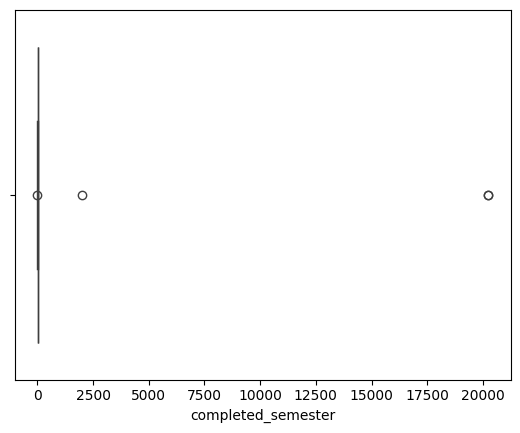

In [261]:
sns.boxplot(x="completed_semester",data=train)
plt.show()

In [262]:
#이상값 확인
train.loc[train["completed_semester"]>20,["completed_semester"]]

,completed_semester
105,2020.02
160,20241.00
214,20241.00


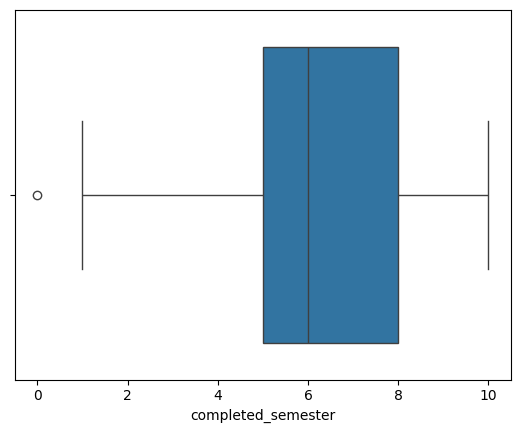

In [263]:
#이상값들은 이상값을 제외하고 계산한 평균값으로 대체
outlier = train[train["completed_semester"] >= 20].index

mean_without_outliers = train.loc[~train.index.isin(outlier), "completed_semester"].mean()
train.loc[outlier, "completed_semester"] = mean_without_outliers

sns.boxplot(x="completed_semester",data=train)
plt.show()

In [264]:
imputer2 = SimpleImputer(strategy = 'mean')
train[['completed_semester']] = imputer2.fit_transform(train[['completed_semester']])
test[['completed_semester']] = imputer2.transform(test[['completed_semester']])

train["completed_semester"].isna().sum()

np.int64(0)

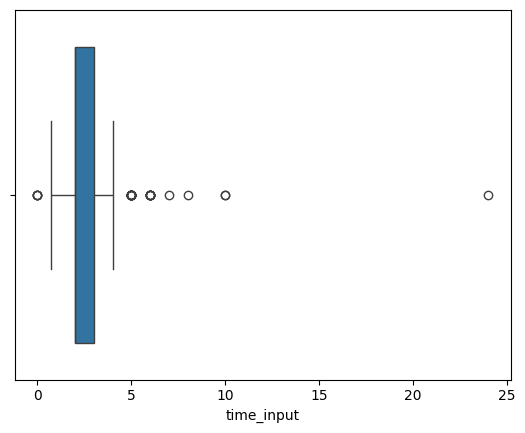

In [265]:
sns.boxplot(x="time_input",data=train)
plt.show()

In [266]:
train["time_input"].describe()

,time_input
count,726.000000
mean,2.334986
std,1.375385
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,24.000000


In [267]:
train["certificate_acquisition"].value_counts()

,count
certificate_acquisition,
없음,445
ADsP,104
"ADsP, SQLD",64
SQLD,47
구글 애널리스트,11
"ADsP, 빅데이터 분석 기사",6
정보처리기사,5
"ADsP, SQLD, 정보처리기사",5
"ADsP, 정보처리기사",4


In [268]:
#자격증이 없으면 1, 있으면 0을 출력하는 함수 생성
nothing_kw = ['없음', '기타', '준비중']

def cert_no(x):
   x = str(x).lower()
   return int(any(keyword in x for keyword in nothing_kw))

for df in [train, test]:
    df['certificate_no'] = df['certificate_acquisition'].apply(cert_no)
    df.drop(columns=['certificate_acquisition'], inplace=True)

In [269]:
train["certificate_no"].value_counts()

,count
certificate_no,
1,455
0,271


In [270]:
train.isna().sum()

,0
ID,0
generation,0
school1,0
major type,0
major1_1,0
major1_2,418
major_data,0
job,0
class1,0
class2,561


In [271]:
target = 'completed'
X = train.drop(target, axis=1)
Y = train.loc[:, target]

In [272]:
#필요한 범주형 변수에 대해 가변수화
cat_cols = ['major_type','major_data','job','re_registration','project_type','desired_career_path','group_y_n','inflow_category']

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X.head()

,ID,generation,school1,major type,major1_1,major1_2,class1,class2,class3,class4,...,job_직장인,job_취준생,re_registration_예,project_type_팀,desired_career_path_이직,desired_career_path_창업,desired_career_path_취업,group_y_n_YES,inflow_category_온라인 유입,inflow_category_지인 추천
0,TRAIN_000,9,22,"복수 전공 ( 다중전공, 이중전공 포함 )",경제통상학,자연과학,1,4.0,NaN,NaN,...,False,False,False,True,False,False,False,True,True,False
1,TRAIN_001,9,1,"복수 전공 ( 다중전공, 이중전공 포함 )",자연과학,IT(컴퓨터 공학 포함),8,NaN,NaN,NaN,...,False,False,False,True,False,False,True,True,False,True
2,TRAIN_002,9,27,단일 전공,예체능,NaN,7,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,True,False
3,TRAIN_003,9,1,"복수 전공 ( 다중전공, 이중전공 포함 )",사회과학,IT(컴퓨터 공학 포함),7,NaN,NaN,NaN,...,False,False,False,True,False,False,True,True,True,False
4,TRAIN_004,9,16,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),8,NaN,NaN,NaN,...,False,False,False,True,False,False,True,True,False,True


In [273]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726 entries, 0 to 747
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               726 non-null    object 
 1   generation                       726 non-null    int64  
 2   school1                          726 non-null    int64  
 3   major type                       726 non-null    object 
 4   major1_1                         726 non-null    object 
 5   major1_2                         308 non-null    object 
 6   major_data                       726 non-null    bool   
 7   job                              726 non-null    object 
 8   class1                           726 non-null    int64  
 9   class2                           165 non-null    float64
 10  class3                           13 non-null     float64
 11  class4                           1 non-null      float64
 12  re_registration            

In [274]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726 entries, 0 to 747
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 726 non-null    object 
 1   generation                         726 non-null    int64  
 2   school1                            726 non-null    int64  
 3   major type                         726 non-null    object 
 4   major1_1                           726 non-null    object 
 5   major1_2                           308 non-null    object 
 6   class1                             726 non-null    int64  
 7   class2                             165 non-null    float64
 8   class3                             13 non-null     float64
 9   class4                             1 non-null      float64
 10  contest_award                      0 non-null      float64
 11  nationality                        725 non-null    object 
 12 

In [275]:
Y.info()

<class 'pandas.core.series.Series'>
Index: 726 entries, 0 to 747
Series name: completed
Non-Null Count  Dtype
--------------  -----
726 non-null    int64
dtypes: int64(1)
memory usage: 27.5 KB


In [276]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               814 non-null    object 
 1   generation                       814 non-null    int64  
 2   school1                          814 non-null    int64  
 3   major type                       740 non-null    object 
 4   major1_1                         741 non-null    object 
 5   major1_2                         631 non-null    object 
 6   major_data                       814 non-null    bool   
 7   job                              814 non-null    object 
 8   class1                           814 non-null    int64  
 9   class2                           242 non-null    float64
 10  class3                           46 non-null     float64
 11  class4                           7 non-null      float64
 12  re_registration       

**- 데이터 전처리 현황**
* major_type : train / test ->결측값 22개는 '기타' -> 복수전공/단일전공/기타
* major_data : train / test -> TRUE/FALSE
* job : train / test -> 대학생/취준생/직장인/대학원생
* only_one_class : train / test -> 1(하나만 수강)/0(여러개 수강)
* re_registration : train / test -> 아니요/예
* inflow_category : train / test -> 온라인유입/기존인원/지인추천
* group_y_n : train / test -> YES/NO
* desired_career_path : train / test -> 취업/대학원진학/이직/창업
* major_it : train / test -> 1(IT전공)/0(IT비전공)
* project_type : train / test -> 팀/개인
* completed_semester : train / test -> 실수형
* time_input : train / test-> 실수형
* certificate_no : train / test -> 1(자격증없음)/0(자격증있음)

In [277]:
train['is_train'] = 1
test['is_train'] = 0

# 두 데이터 프레임 합치기 (completed 컬럼 제외)
# test에는 'completed' 컬럼이 없으므로, train에서만 drop합니다.
concat_df = pd.concat([train.drop('completed', axis=1), test])

# 모델링에 사용할 변수 선택 (수치형 + 범주형 모두 포함)
# 주의: 여기서 선택하는 컬럼들은 원본(문자열 포함)이어야 합니다. 인코딩은 그 후에 합니다.
features = [
    'major_type', 'major_data', 'job', 'only_one_class',
    're_registration', 'inflow_category', 'group_y_n',
    'desired_career_path', 'major_it', 'project_type',
    'completed_semester', 'time_input','certificate_no', 'is_train' # is_train 필수 포함
]
concat_select = concat_df[features]

# 가변수화 수행
# 범주형 변수들만 자동으로 변환됩니다.
concat_encoded = pd.get_dummies(concat_select, columns=[
    'major_type', 'major_data', 'job', 're_registration',
    'project_type', 'desired_career_path', 'group_y_n', 'inflow_category'
], drop_first=True)

# 다시 Train / Test로 분리
X_train = concat_encoded[concat_encoded['is_train'] == 1].drop('is_train', axis=1)
X_test = concat_encoded[concat_encoded['is_train'] == 0].drop('is_train', axis=1)
Y_train = train['completed']

# 확인 (컬럼 개수가 동일해야 함)
print(f"학습용 데이터 X_train shape: {X_train.shape}")
print(f"테스트용 데이터 X_test shape: {X_test.shape}")
print(f"정답 데이터 Y_train shape: {Y_train.shape}")

학습용 데이터 X_train shape: (726, 20)
테스트용 데이터 X_test shape: (814, 20)
정답 데이터 Y_train shape: (726,)


In [278]:
X_train.head()

,only_one_class,major_it,completed_semester,time_input,certificate_no,"major_type_복수 전공( 다중전공, 이중전공 포함 )",major_data_True,job_대학원생,job_직장인,job_취준생,re_registration_예,project_type_팀,desired_career_path_이직,desired_career_path_창업,desired_career_path_취업,desired_career_path_현재 직장 유지,group_y_n_YES,inflow_category_기타,inflow_category_온라인 유입,inflow_category_지인 추천
0,0,0,4.0,2.0,0,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False
1,1,0,6.0,3.0,1,True,True,False,False,False,False,True,False,False,True,False,True,False,False,True
2,1,0,8.0,10.0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
3,1,0,8.0,2.0,0,True,False,False,False,False,False,True,False,False,True,False,True,False,True,False
4,1,1,7.0,2.0,0,True,True,False,False,False,False,True,False,False,True,False,True,False,False,True


In [279]:
X_test.head()

,only_one_class,major_it,completed_semester,time_input,certificate_no,"major_type_복수 전공( 다중전공, 이중전공 포함 )",major_data_True,job_대학원생,job_직장인,job_취준생,re_registration_예,project_type_팀,desired_career_path_이직,desired_career_path_창업,desired_career_path_취업,desired_career_path_현재 직장 유지,group_y_n_YES,inflow_category_기타,inflow_category_온라인 유입,inflow_category_지인 추천
0,1,1,5.000000,2.0,1,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,1,5.000000,1.0,1,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False
2,1,0,5.000000,5.0,1,True,True,False,False,False,False,False,False,False,True,False,True,False,True,False
3,0,1,6.000000,4.0,0,True,False,False,False,False,False,True,False,False,True,False,True,False,True,False
4,1,1,6.119944,1.0,1,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/us

<Axes: >

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) m

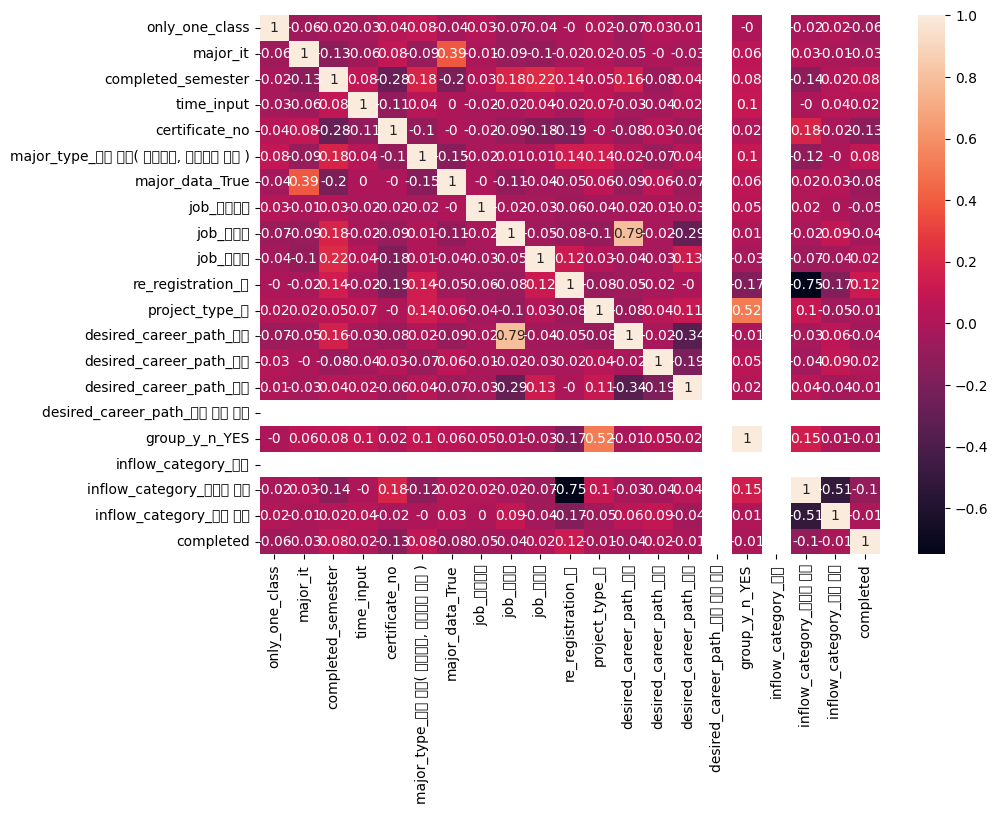

In [280]:
X_train_map = X_train.copy()
X_train_map["completed"] = train["completed"]
plt.figure(figsize=(10,7))  #열들 간 상관계수 히트맵, annot=True는 각 칸에 숫자 표시
sns.heatmap(X_train_map.corr().round(2), annot = True)

**- 모델링**

In [281]:
!pip install catboost

In [282]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [283]:
#XGboost 학습을 위해 컬럼명에 있는 특수문자 제거(오류방지용) -> 컬럼명에 특수문자 있으면 오류 발생 가능성 있음
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns]

In [284]:
#불균형 가중치 계산 (필수)
neg_count = (Y_train == 0).sum()
pos_count = (Y_train == 1).sum()
weight_ratio = neg_count / pos_count

In [285]:
#XGBoost 파라미터 (보수적 설정)
xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 4,
    'gamma': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_jobs': -1,
    'reg_alpha': 0.1,
    'reg_lambda': 5.0,
    'scale_pos_weight': np.sqrt(weight_ratio),
    'early_stopping_rounds': 50}

In [286]:
#CatBoost 파라미터 (과적합 방지 및 소규모 데이터 최적화)
cat_params = {
    'iterations': 2000,
    'learning_rate': 0.015,
    'depth': 7, # XGB보다 약간 깊게 줘도 됨
    'l2_leaf_reg':7, # 규제 강화
    'auto_class_weights': 'Balanced', # 불균형 자동 처리
    'early_stopping_rounds': 100,
    'verbose': 0,
    'allow_writing_files': False}

In [287]:
#시드 설정
seeds = [42, 2026, 1, 11, 24, 3514, 486, 3614, 1225, 7777, 2000, 8, 16, 5, 7074]
n_splits = 15

#결과 저장소
final_oof_xgb = np.zeros(len(X_train))
final_test_xgb = np.zeros(len(X_test))
final_oof_cat = np.zeros(len(X_train))
final_test_cat = np.zeros(len(X_test))

print(f"--- 총 {len(seeds)}개의 Seed로 앙상블 학습을 시작합니다 ---")

#시드 루프 (전체 앙상블)
for i, seed in enumerate(seeds):
    print(f"[Seed {seed} 학습 시작 ({i+1}/{len(seeds)})]")

    # 해당 시드의 파라미터 업데이트
    current_params = xgb_params.copy()
    current_params['random_state'] = seed

    # 해당 시드의 결과를 담을 임시 저장소
    seed_oof_xgb = np.zeros(len(X_train))
    seed_test_xgb = np.zeros(len(X_test))
    seed_oof_cat = np.zeros(len(X_train))
    seed_test_cat = np.zeros(len(X_test))

    # K-Fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        #XGBoost학습
        xgb_p = xgb_params.copy()
        xgb_p["random_state"] = seed
        model_xgb = XGBClassifier(**xgb_params)
        model_xgb.fit(x_tr, y_tr, eval_set=[(x_val, y_val)], verbose=False)

        #XGBoost예측
        seed_oof_xgb[val_idx] = model_xgb.predict_proba(x_val, iteration_range=(0, model_xgb.best_iteration + 1))[:, 1]
        seed_test_xgb += model_xgb.predict_proba(X_test, iteration_range=(0, model_xgb.best_iteration + 1))[:, 1] / n_splits

        #CatBoost학습
        cat_p = cat_params.copy()
        cat_p['random_seed'] = seed
        model_cat = CatBoostClassifier(**cat_p)
        model_cat.fit(x_tr, y_tr, eval_set=(x_val, y_val), verbose=False)

        #CatBoost예측
        seed_oof_cat[val_idx] = model_cat.predict_proba(x_val)[:, 1]
        seed_test_cat += model_cat.predict_proba(X_test)[:, 1] / n_splits

    # 시드별 결과 누적
    final_oof_xgb += seed_oof_xgb / len(seeds)
    final_test_xgb += seed_test_xgb / len(seeds)
    final_oof_cat += seed_oof_cat / len(seeds)
    final_test_cat += seed_test_cat / len(seeds)

#모델 혼합(5:5비율)
final_oof_pred = (final_oof_xgb * 0.3) + (final_oof_cat * 0.7)
final_test_pred = (final_test_xgb * 0.3) + (final_test_cat * 0.7)

#최적의 Threshold 찾기
best_thr = 0.5
best_f1 = 0

for thr in np.arange(0.1, 0.8, 0.01):
    pred_temp = (final_oof_pred >= thr).astype(int)
    score = f1_score(Y_train, pred_temp)
    if score > best_f1:
        best_f1 = score
        best_thr = thr

print(f"최적 임계값(Threshold): {best_thr:.2f}")
print(f"예상 F1 Score (CV): {best_f1:.4f}")

# --- 4. 제출 파일 생성 ---
final_pred = (final_test_pred >= best_thr).astype(int)


--- 총 15개의 Seed로 앙상블 학습을 시작합니다 ---
[Seed 42 학습 시작 (1/15)]
[Seed 2026 학습 시작 (2/15)]
[Seed 1 학습 시작 (3/15)]
[Seed 11 학습 시작 (4/15)]
[Seed 24 학습 시작 (5/15)]
[Seed 3514 학습 시작 (6/15)]
[Seed 486 학습 시작 (7/15)]
[Seed 3614 학습 시작 (8/15)]
[Seed 1225 학습 시작 (9/15)]
[Seed 7777 학습 시작 (10/15)]
[Seed 2000 학습 시작 (11/15)]
[Seed 8 학습 시작 (12/15)]
[Seed 16 학습 시작 (13/15)]
[Seed 5 학습 시작 (14/15)]
[Seed 7074 학습 시작 (15/15)]
최적 임계값(Threshold): 0.39
예상 F1 Score (CV): 0.5043


In [289]:
sample_submission['completed'] = final_pred
sample_submission.to_csv('submit_kfold_xgb_cat11.csv', index=False)
print("submit_kfold_xgb_cat11.csv 저장 완료!")

submit_kfold_xgb_cat11.csv 저장 완료!
